# Notebook for getting S$_{21}$s of resonators vs power

Loading libraries requred below:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import time
import pickle
import sys
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
import os

In [3]:
from drivers.Agilent_PNA_L import Agilent_PNA_L

In [4]:
from importlib import reload

In [5]:
import drivers

### Setting the name for the sample

In [11]:
sample_name = "Xmon AL BMSTU 1 190317"

### Getting the general view S$_{21}$ scan of the sample and detect resonator positions

In [6]:
vna = Agilent_PNA_L("PNA-L2")# loading the vector network analyser object from the driver

In [7]:
vna.sweep_hold()

Setting the parameters of the scan:

In [11]:
vna.set_xlim(6.5e9, 8e9) # setting the scan area

In [12]:
vna.set_bandwidth(1000)

True

In [13]:
vna.set_nop(20001)
vna.set_averages(1)

True

In [14]:
vna.set_power(-10)

True

In [15]:
vna.prepare_for_stb()
vna.sweep_single() # triggering the sweep
vna.wait_for_stb()
vna.autoscale_all()

In [49]:
def guess_scan_areas(area_size, depth):
    '''
    Function to get the approximate positions of the resonator dips and return small areas around them
    Parameters:
    -----------
        area_size : double
        Sets the diams of the returned scan areas (Hz)
        
        depth : double
        Count everything deeper than median transmission depth near a minimum as a resonator dip. 
        Should be chosen manually each time
    Returns:
        scan_areas : list
        A list of tuples each representing an area in frequency presumably around the resonator dips
    '''
    freqs, amps = vna.get_frequencies(), 20*log10(abs(vna.get_sdata()))
    window = 100
    extrema = argrelextrema(amps, np.less, order=window)[0]
    deep_minima = []
    for extremum in extrema:
        mean_transmission = median(amps[extremum-window/2:extremum+window/2])
        if amps[extremum]<mean_transmission-depth:
            deep_minima.append(freqs[extremum])
    return [(m-area_size/2, m+area_size/2) for m in deep_minima]

In [59]:
scan_areas = guess_scan_areas(10e6, 1)[:]
scan_areas[:10], len(scan_areas)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


([(6616500000.0, 6626500000.0),
  (6707100000.0, 6717100000.0),
  (6796950000.0, 6806950000.0),
  (6884925000.0, 6894925000.0),
  (6975075000.0, 6985075000.0),
  (7064250000.0, 7074250000.0),
  (7476600000.0, 7486600000.0),
  (7734375000.0, 7744375000.0)],
 8)

In [96]:
# scan_areas_prepend = [(5563624000.0, 5564624000.0)]

In [56]:
# manual override for the scan areas, don't use if guessing succeeded
# scan_areas = [(4.91e9,4.95e9), (6.22e9, 6.26e9)] 
# scan_areas.append((7.7e9, 7.8e9))
# scan_areas[7] = (7.737e9, 7.741e9)
# scan_areas.insert(-1, (7.48e9, 7.488e9))
del scan_areas[1]

In [50]:
# scan_areas = scan_areas+scan_areas_prepend

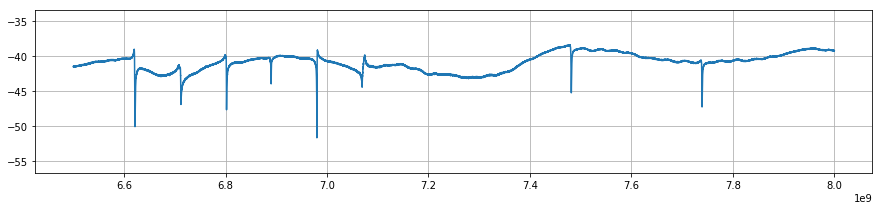

In [65]:
save_graph = True

plt.plot(vna.get_frequencies(), 20*log10(abs(vna.get_sdata())))

if not save_graph:
    for scan_area in scan_areas:
        plt.plot(scan_area, ones(2)*min(20*log10(abs(vna.get_sdata()))), marker="+")
        
# plt.xlim(scan_areas[2]) # the x-axis limits may are set to a certain scan area to check whether it was guessed correctly
plt.ylim(min(20*log10(abs(vna.get_sdata())))-5,max(20*log10(abs(vna.get_sdata())))+5)
# plt.xlim(6.5e9, 8e9)
# plt.minorticks_on()
plt.grid(which="both")
plt.gcf().set_size_inches(15, 3)

# Here the first datafile is created. It is placed in a folder with current date which is also created below.

if save_graph:
    try:
        os.mkdir("./data/"+str(datetime.datetime.now().date()))
    except FileExistsError:
        pass
    with open("./data/"+str(datetime.datetime.now().date())+"/"+sample_name+".pkl", "wb") as f:
        pickle.dump((vna.get_frequencies(), vna.get_sdata()), f)

### Recording a zoomed scan inside each scan area at each power

In [66]:
power_scans = {}
vna.set_nop(1000)
vna.set_bandwidth(5000)

True

First we make noise calibration to make sure we will not perform redundant averaging:

In [67]:
def theory_noise_amps_pow(power, exponent, max_noise):
    return max_noise*exp(-power*exponent)
# def theory_noise_amps_avg(average, max_noise):
#     return max_noise/sqrt(average)
def calibrate_noise(scan_area, powers):
    noises = []
    vna.set_xlim(*(mean(scan_area)+10e6+linspace(-1,1,2)))
    vna.set_averages(1)
    for power in powers:
        vna.set_power(power)
        vna.prepare_for_stb()
        vna.sweep_single()
        vna.wait_for_stb()
        noises.append(vna.get_sdata())
        print("\rPower:", power, end="")
    noise_amps = [sqrt(sum(abs(noise - mean(noise))**2)) for noise in noises] 
    opt_params = curve_fit(theory_noise_amps_pow, powers, noise_amps, p0=(0.01,0.1))[0]
    return opt_params, noise_amps

In [69]:
time_start = datetime.datetime.now()
print("Started at:", time_start)

powers = linspace(-60, 0, 61) # the powers we are using to scan through
print(powers[:5]) # to check the powers are nice whole numbers

# Beginning the scan here             
for scan_area in scan_areas[:]:
    S21s = []
    
    opt_params, noise_amps = calibrate_noise(scan_area, powers[::10])
    averages_arr = around(300*theory_noise_amps_pow(powers, *opt_params)**2)
    averages_arr[averages_arr==0]=1
    vna.set_xlim(*scan_area)
    
    for power, averages in zip(powers, averages_arr):
        vna.set_power(power)
        vna.set_averages(averages)
        print("\r"+str(scan_area), "avg: "+str(averages), "power:"+str(power), end=" ", flush=True)
        
        vna.prepare_for_stb()
        vna.sweep_single()
        vna.wait_for_stb()
        
        vna.autoscale_all()
        S21s.append((vna.get_frequencies(), vna.get_sdata()))
    power_scans[scan_area] = S21s
    print("Done!")
with open("./data/"\
          +str(time_start.date())\
          +"/"+sample_name+"_resonators_on_power.pkl", "wb") as f:
    pickle.dump((scan_areas, powers, power_scans), f)

Started at: 2017-03-19 22:00:19.697785
[-60. -59. -58. -57. -56.]
(6616500000.0, 6626500000.0) avg: 1.0 power:0.0     Done!
(6707100000.0, 6717100000.0) avg: 1.0 power:0.0     Done!
(6796950000.0, 6806950000.0) avg: 1.0 power:0.0     Done!
(6884925000.0, 6894925000.0) avg: 1.0 power:0.0     Done!
(6975075000.0, 6985075000.0) avg: 1.0 power:0.0     Done!
(7064250000.0, 7074250000.0) avg: 1.0 power:0.0     Done!
(7476600000.0, 7486600000.0) avg: 1.0 power:0.0     Done!
(7734375000.0, 7744375000.0) avg: 1.0 power:0.0     Done!


In [ ]:
scan_area

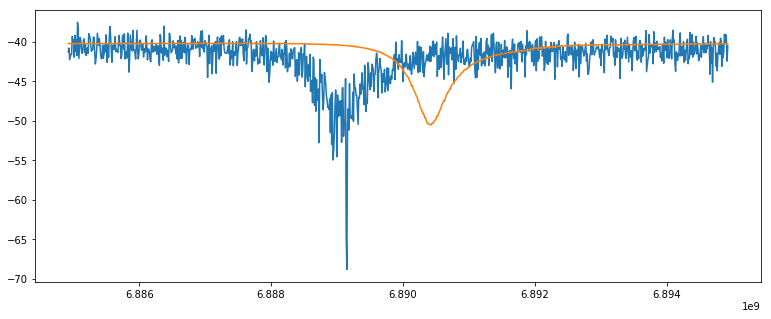

In [73]:
scan_area = scan_areas[3]
plt.plot(power_scans[scan_area][0][0], 20*log10(abs(power_scans[scan_area][0][1])))
plt.plot(power_scans[scan_area][-1][0], 20*log10(abs(power_scans[scan_area][-1][1])))
plt.gcf().set_size_inches(13,5)

## Individual fit 

In [50]:
from resonator_tools.circuit import notch_port as np

In [51]:
# port = np(power_scans[scan_area][-1][0], power_scans[scan_area][-1][1])
port = np(vna.get_frequencies(), vna.get_sdata())

C:\ProgramData\Anaconda3\lib\site-packages\resonator_tools-0.1-py3.6.egg\resonator_tools\circuit.py:195: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\ProgramData\Anaconda3\lib\site-packages\resonator_tools-0.1-py3.6.egg\resonator_tools\circuit.py:199: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [52]:
port.autofit()

C:\ProgramData\Anaconda3\lib\site-packages\resonator_tools-0.1-py3.6.egg\resonator_tools\circuit.py:294: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [53]:
port.fitresults

{'Qc_dia_corr': 10216.821311925491,
 'Qi_dia_corr': 32341.445812501024,
 'Qi_dia_corr_err': 1504.1966635916367,
 'Qi_no_corr': 32400.490614148879,
 'Qi_no_corr_err': 1519.0465822682781,
 'Ql': 7764.103079422468,
 'Ql_err': 116.64474286107988,
 'absQc': 10210.943004428822,
 'absQc_err': 105.87124426497405,
 'chi_square': 0.0060663943007424692,
 'fr': 7910855498.279562,
 'fr_err': 8750.5339258566419,
 'phi0': -0.033923767195688008,
 'phi0_err': 0.014979716862754918,
 'theta0': 3.1076688863941051}

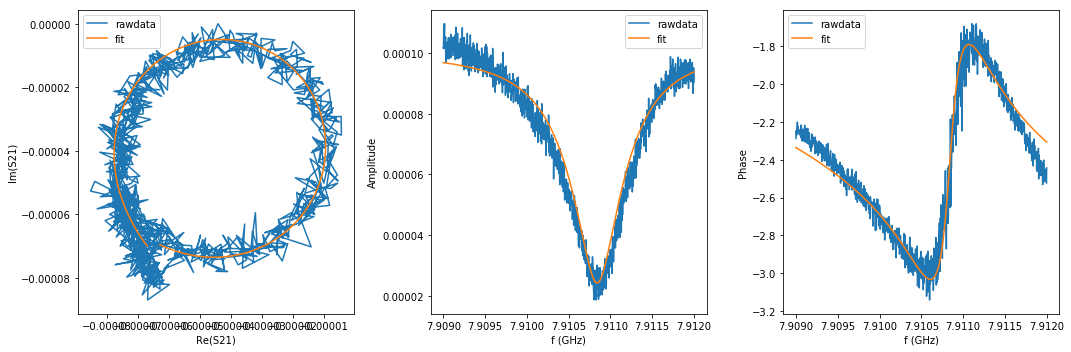

In [54]:
port.plotall()